# Visualize benchmarking results

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', palette='deep', font='sans-serif', font_scale=1.2, color_codes=True, rc=None)

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

## Read results

In [3]:
### Null simulation ###
null_sim_hitrates = pd.read_csv('results/benchmark/null_sim_hitrates.tsv', sep='\t', index_col=0)
null_sim_pct_sig_cluster = pd.read_csv('results/benchmark/null_sim_pct_sig_cluster.tsv', sep='\t', index_col=0)
null_sim_hitrate_cluster_rep = pd.read_csv('results/benchmark/null_sim_rep_hitrate_cluster.tsv', sep='\t', index_col=0)
null_sim_hitrate_cluster_norep = pd.read_csv('results/benchmark/null_sim_norep_hitrate_cluster.tsv', sep='\t', index_col=0)

### Simulation with differences ###
difs_sim_hitrates = pd.read_csv('results/benchmark/difs_sim_hitrates.tsv', sep='\t', index_col=0)
difs_sim_pct_sig_cluster = pd.read_csv('results/benchmark/difs_sim_pct_sig_cluster.tsv', sep='\t', index_col=0)
difs_sim_hitrate_cluster_rep = pd.read_csv('results/benchmark/difs_sim_rep_hitrate_cluster.tsv', sep='\t', index_col=0)
difs_sim_hitrate_cluster_norep = pd.read_csv('results/benchmark/difs_sim_norep_hitrate_cluster.tsv', sep='\t', index_col=0)

### Benchmarking bootstrapping ###
benchmark_hit_rates = pd.read_csv('results/benchmark/benchmark_hitrates.tsv', sep='\t')
benchmark_stats = pd.read_csv('results/benchmark/benchmark_stats.tsv', sep='\t')
best_auroc = pd.read_csv('results/benchmark/benchmark_best_auroc.tsv', sep='\t')

## Plots

### Null simulation hit rates

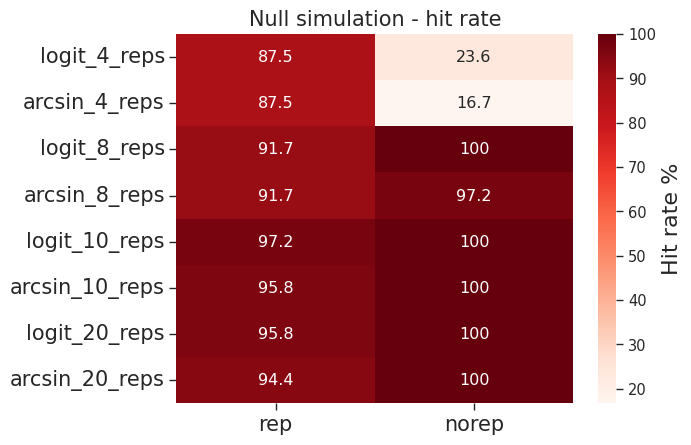

In [4]:
ax = sns.heatmap(null_sim_hitrates, annot=True, cmap="Reds", cbar_kws={'label': 'Hit rate %'}, fmt='0.3g')

ax.set_title('Null simulation - hit rate', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(16)  # colorbar

plt.savefig(f'{FIG_PATH}/null_simulation_heatmap.pdf', dpi=300, bbox_inches='tight')

plt.show()

### Simulation with differences hit rates

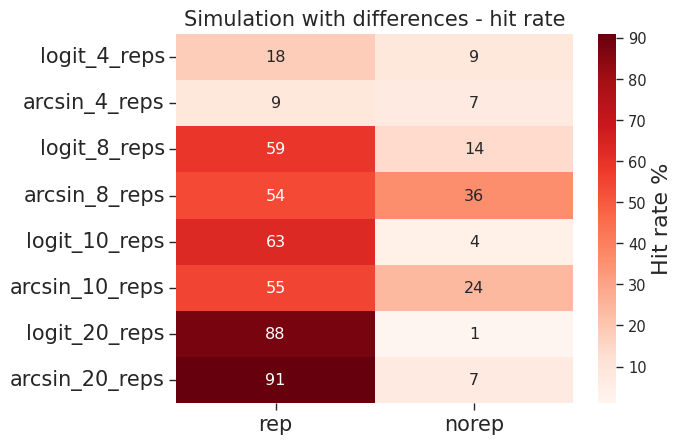

In [5]:
ax = sns.heatmap(difs_sim_hitrates, annot=True, cmap="Reds", cbar_kws={'label': 'Hit rate %'}, fmt='0.3g')

ax.set_title('Simulation with differences - hit rate', fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
ax.figure.axes[-1].yaxis.label.set_size(16)  # colorbar

plt.savefig(f'{FIG_PATH}/difs_simulation_heatmap.pdf', dpi=300, bbox_inches='tight')

plt.show()

### Correct assignment per cluster

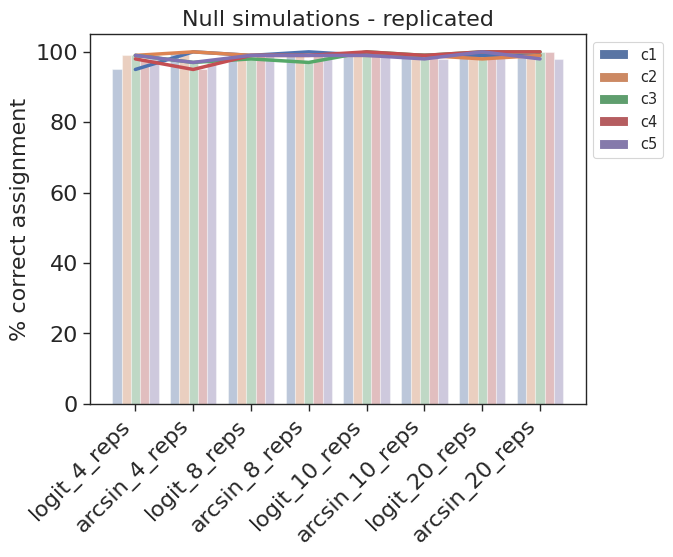

In [6]:
ax = sns.barplot(data=null_sim_hitrate_cluster_rep, x='method', y='hit_rate', hue='cluster', alpha=0.4)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]

# plot hit rate as lineplot
sns.lineplot(data=null_sim_hitrate_cluster_rep, x='method', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

ax.set_ylabel("% correct assignment", fontsize=16)
ax.set_xlabel("")
ax.set_title('Null simulations - replicated', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)



plt.savefig(f'{FIG_PATH}/null_simulation_rep_hitrate_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

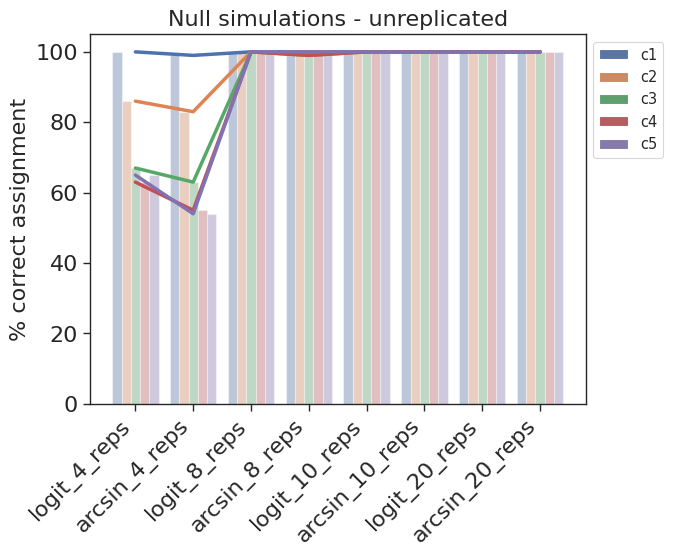

In [7]:
ax = sns.barplot(data=null_sim_hitrate_cluster_norep, x='method', y='hit_rate', hue='cluster', alpha=0.4)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plot hit rate as lineplot
sns.lineplot(data=null_sim_hitrate_cluster_norep, x='method', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)

ax.set_ylabel("% correct assignment", fontsize=16)
ax.set_xlabel("")
ax.set_title('Null simulations - unreplicated', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f'{FIG_PATH}/null_simulation_norep_hitrate_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

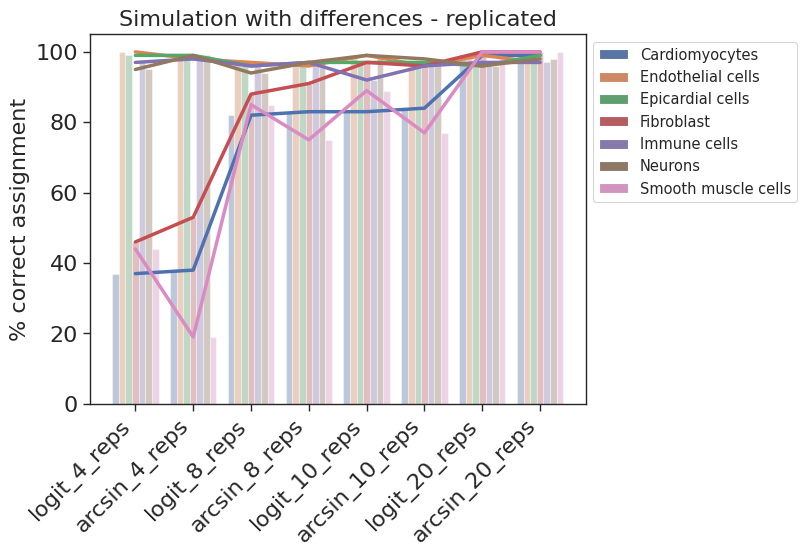

In [8]:
ax = sns.barplot(data=difs_sim_hitrate_cluster_rep, x='method', y='hit_rate', hue='cluster', alpha=0.4)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plot lines
sns.lineplot(data=difs_sim_hitrate_cluster_rep, x='method', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)

ax.set_ylabel("% correct assignment", fontsize=16)
ax.set_xlabel("")
ax.set_title('Simulation with differences - replicated', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f'{FIG_PATH}/difs_simulation_rep_clusters.pdf', dpi=300, bbox_inches='tight')


plt.show()

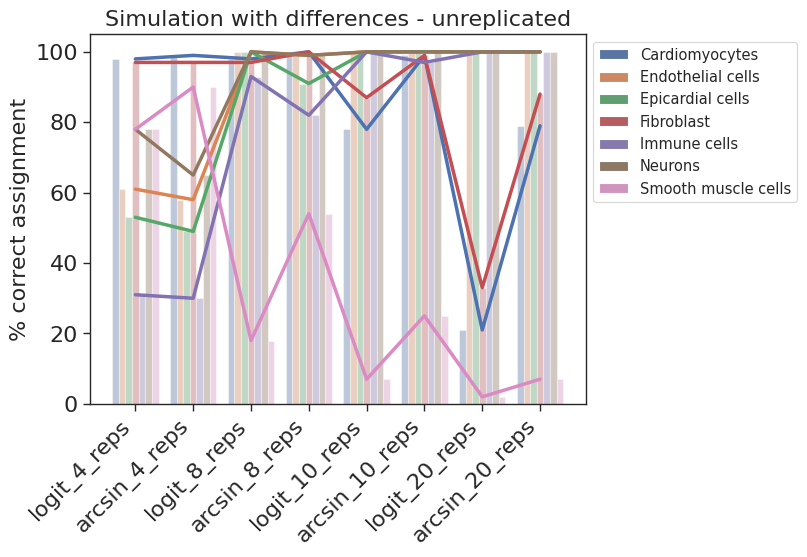

In [9]:
ax = sns.barplot(data=difs_sim_hitrate_cluster_norep, x='method', y='hit_rate', hue='cluster', alpha=0.4)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
legend = ax.legend(loc="upper right")
[legend.legend_handles[i].set_alpha(1) for i in range(len(legend.legend_handles))]
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# plot line plot
sns.lineplot(data=difs_sim_hitrate_cluster_norep, x='method', y='hit_rate', hue='cluster', ax=ax, linewidth=2.5, legend=False)

ax.set_ylabel("% correct assignment", fontsize=16)
ax.set_xlabel("")
ax.set_title('Simulation with differences - unreplicated', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f'{FIG_PATH}/difs_simulation_norep_clusters.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Benchmarking bootstrapping

### sensitivity vs false positive rate

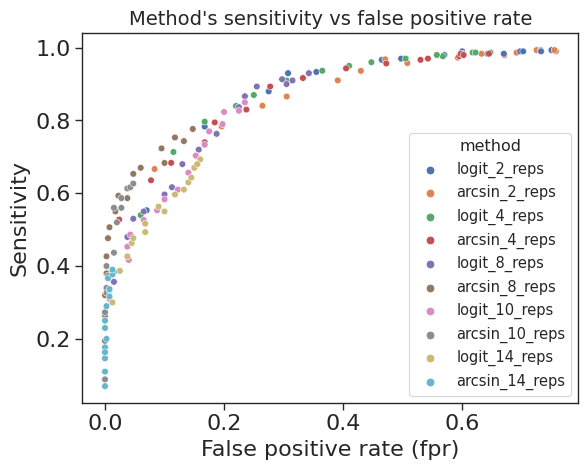

In [10]:
ax = sns.scatterplot(data=benchmark_stats, x='fpr', y='sensitivity', hue='method')

ax.set_ylabel('Sensitivity', fontsize=16)
ax.set_xlabel('False positive rate (fpr)', fontsize=16)

ax.set_title("Method's sensitivity vs false positive rate", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(f'{FIG_PATH}/benchmark_sensitivity_fpr.pdf', dpi=300, bbox_inches='tight')

### Mean counts vs auroc

In [11]:
# read best auroc per mean count data
best_auroc = pd.read_csv('results/benchmark/benchmark_best_auroc.tsv', sep='\t')
# extract number of reps with best auroc per mean counts
best_reps = best_auroc.drop_duplicates(['reps'], keep='last')['mean_counts'].to_list()
n_reps = best_auroc.drop_duplicates(['reps'], keep='last')['reps'].to_list()

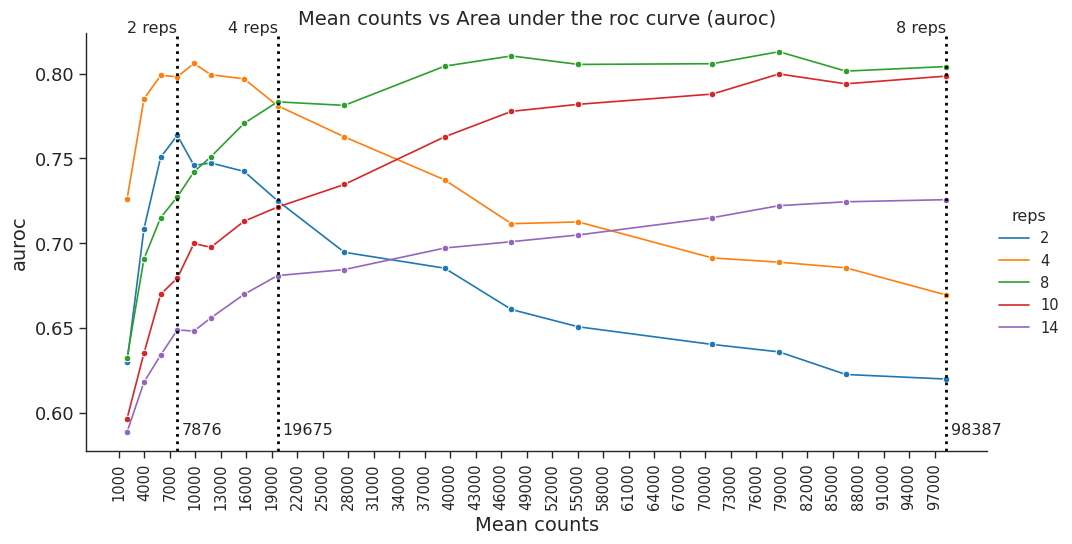

In [12]:
ticks = np.arange(1000, 100000, 3000)
x_labels = [str(label) for label in ticks]

plot_3 = sns.relplot(data=benchmark_stats, x='mean_counts', y='auroc', kind='line', errorbar=None,
                     hue='reps', aspect=2, marker='o', palette='tab10')

for ax in plot_3.axes.flatten():
    ax.set_xticks(ticks, x_labels, rotation=90, ha='center')
    ax.set(xlabel='Mean counts', ylabel='auroc')

ax.set_ylabel('auroc', fontsize=14)
ax.set_xlabel('Mean counts', fontsize=14)

ax.set_title("Mean counts vs Area under the roc curve (auroc)", fontsize=14)

plt.tick_params(axis='y', which='major', labelsize=13)

# plot ranges of best number of replicates
for i in range(len(best_reps)):
    ax.axvline(best_reps[i], ls=':', color='black', linewidth=2)
    ax.text(best_reps[i], ax.get_ylim()[1], f'{n_reps[i]} reps', ha='right')
    ax.text(best_reps[i]+500, ax.get_ylim()[0]+0.01, f'{int(best_reps[i])}', ha='left')
    
    
plt.savefig(f'{FIG_PATH}/benchmark_mean_counts_auroc.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [13]:
# get results files path
result_files = glob.glob("results/benchmark/raw/*")

base = [os.path.splitext(os.path.basename(f))[0] for f in result_files]
methods = set([a.split("_", 3)[3] for a in base])

In [14]:
data = {method: {"rep": pd.read_csv(f'results/benchmark/raw/difs_sim_rep_{method}.tsv', sep="\t"),
                "norep": pd.read_csv(f'results/benchmark/raw/difs_sim_norep_{method}.tsv', sep="\t")} for method in methods}

mean_props = {method: data[method]['rep'].reset_index().groupby('clusters').mean()['baseline_props'].to_list() for method in methods}

plot_titles = {method: method for method in methods}

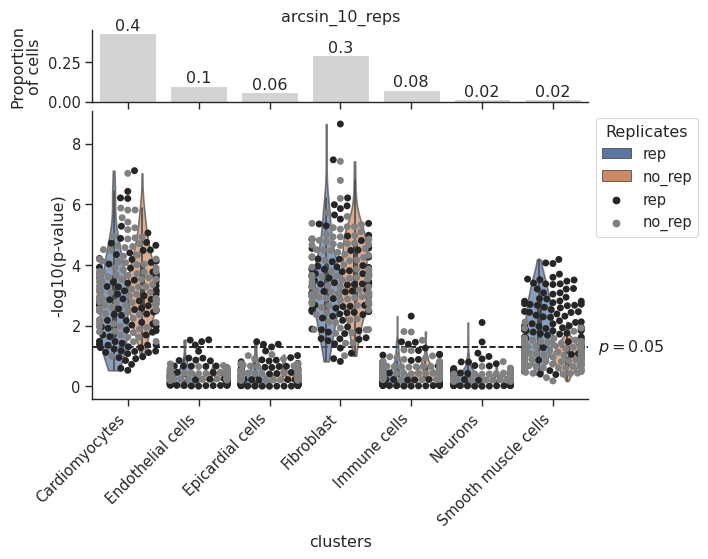

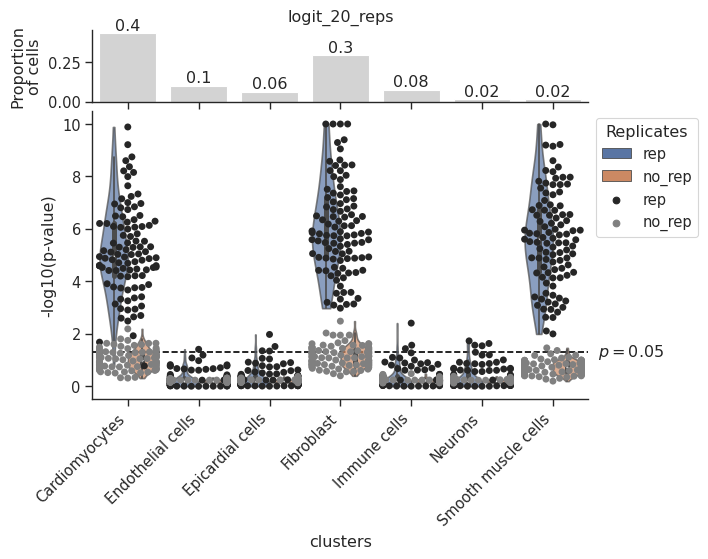

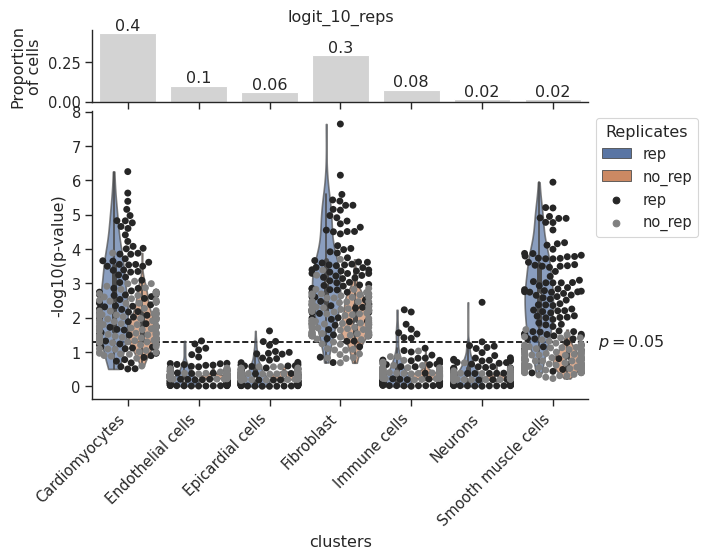

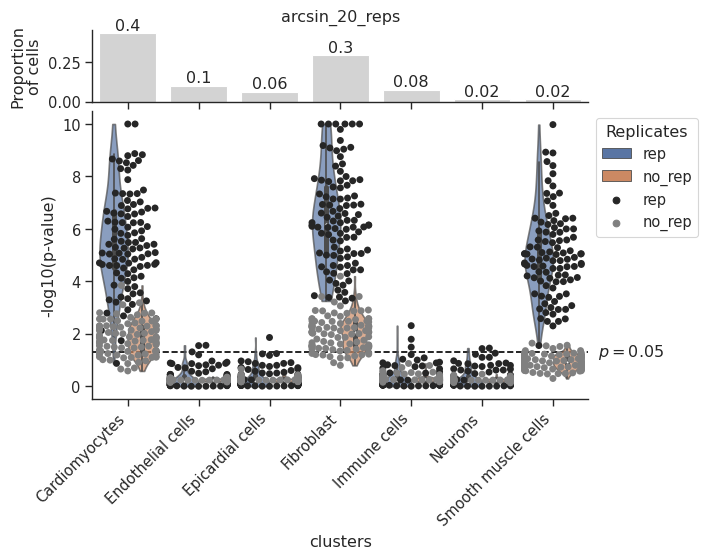

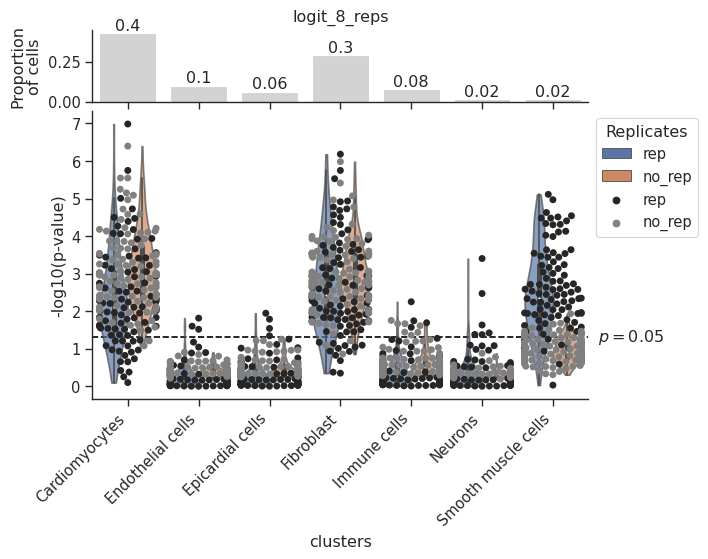

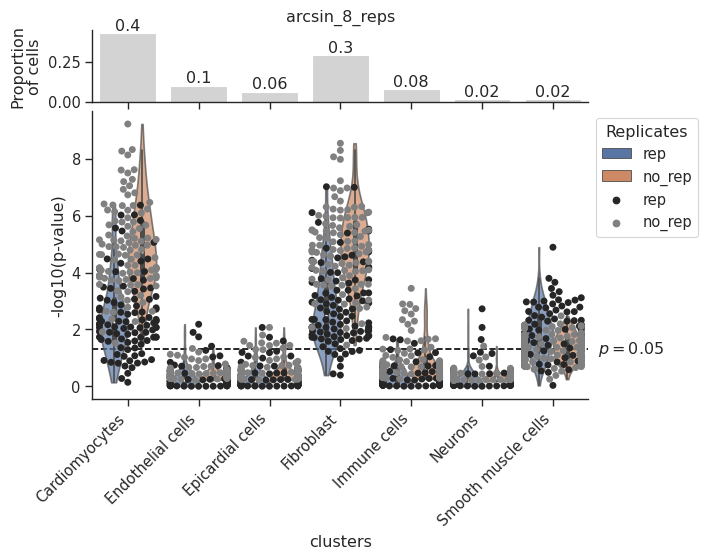

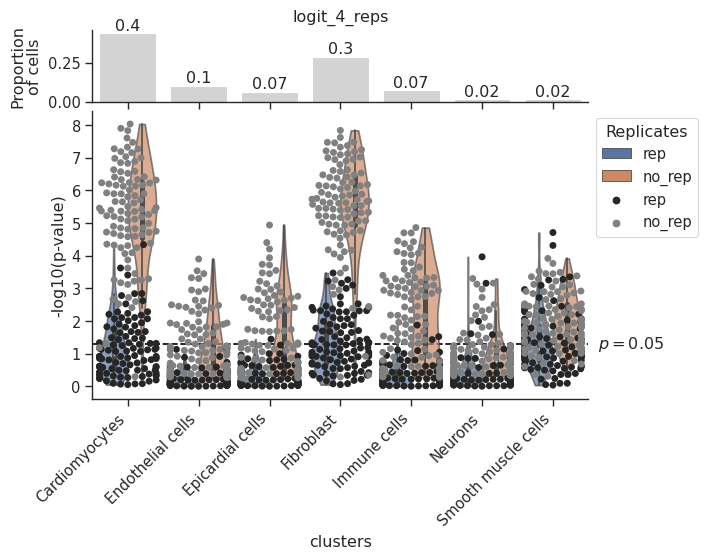

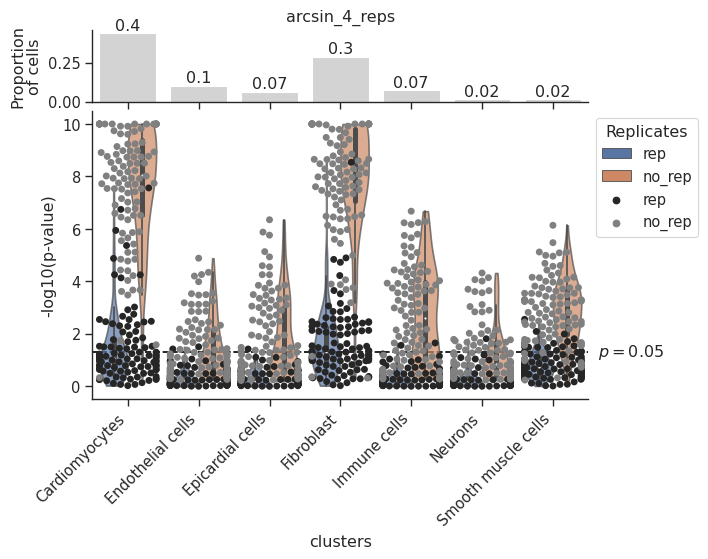

In [15]:
import warnings
warnings.filterwarnings("ignore")

for dataset in data:
    
    # Prepare data
    data_norep = data[dataset]["norep"].copy()
    data_rep = data[dataset]["rep"].copy()
    # replace very small p-values
    data_norep.iloc[:, -1] = np.where(data_norep.iloc[:, -1] < 10**-10, 10**-10, data_norep.iloc[:, -1])
    data_rep.iloc[:, -1] = np.where(data_rep.iloc[:, -1] < 10**-10, 10**-10, data_rep.iloc[:, -1])
    # convert to log(p-values)
    data_norep["-log10(p-value)"] = -np.log10(data_norep.iloc[:,-1])
    data_rep["-log10(p-value)"] = -np.log10(data_rep.iloc[:,-1])
    
    data_norep["Replicates"] = "no_rep"
    data_rep["Replicates"] = "rep"
    
    data_all = pd.concat([data_rep, data_norep])
    
    index_name = data_all["clusters"].unique()
    data_norep.reset_index(inplace=True)
    data_rep.reset_index(inplace=True)

    # Prepare plot
    fig, axarr = plt.subplots(2, sharex=True, height_ratios=[0.2,0.8])
    plt.subplots_adjust(hspace=0.05)
    
    for ax in axarr:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    ax = axarr[0]
    
    # Add title to plot
    ax.set_title(plot_titles.get(dataset, ""))

    # Add proportion on top
    ax = axarr[0]
    sns.barplot(x=index_name, y=mean_props[dataset], ax=ax, color="lightgrey")
    ax.set_xlabel("")
    ax.set_ylabel("Proportion\nof cells")
    ax.bar_label(ax.containers[0], fmt='%.g')

    # Plot results of simulated run
    ax = axarr[1]
    sns.violinplot(data_all, x="clusters", y="-log10(p-value)", 
                    cut=0, scale="width", ax=ax, hue="Replicates")
    for violin in ax.collections[::2]:
        violin.set_alpha(0.7)
        
    # Remove duplicates entries in legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[-2:], labels[-2:], loc="upper left", bbox_to_anchor=(1.05,1))
    
    sns.swarmplot(data_all, x="clusters", y="-log10(p-value)", color="grey", ax=ax,
                  hue="Replicates")
    
    # Plot threshold line
    pvalue_threshold = -np.log10(0.05)
    ax.axhline(pvalue_threshold, zorder=0, color="black", ls="--")
    ax.text(ax.get_xlim()[1], pvalue_threshold, "  $\it{p=0.05}$", va="center")
    
    # Set xticklabels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.savefig(f"plots/{dataset}_bootstrap_comparison.pdf", dpi=300, bbox_inches="tight")
    plt.show()